<a href="https://colab.research.google.com/github/statrav/pages/blob/main/StyleCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CLIP library 설치

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 749 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-j42jc6w4
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-j42jc6w4
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=72c30ac98085b18b02cea4b20ba51475e1e224ec98cdd7ef37d8f212c64adfca
  Stored in directory: /tmp/pip-ephem-wheel-cache-auf4sbyp/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip


In [2]:
# 사전 학습된 StyleGAN Model Load

!git clone https://github.com/ndb796/StyleCLIP-Tutorial
%cd StyleCLIP-Tutorial

Cloning into 'StyleCLIP-Tutorial'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 64 (delta 19), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (64/64), done.
/content/StyleCLIP-Tutorial


In [3]:
# StyleGAN2 version Model 가중치(weight) 다운
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1 -O stylegan2-ffhq-config-f.pt

--2022-12-26 08:21:34--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt?ga=1 [following]
--2022-12-26 08:21:35--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 381462551 (364M) [application/octet-stream]
Saving to: ‘stylegan2-ffhq-config-f.pt’

stylegan2-ffhq-conf 100%[===================>] 363.79M   108MB/s    in 4.3s    

2022-12-26 08:21:39 (85.2

In [4]:
# 생성자 모델 초기화

import torch
from stylegan2.model import Generator


g_ema = Generator(1024, 512, 8)
g_ema.load_state_dict(torch.load('stylegan2-ffhq-config-f.pt')["g_ema"], strict=False)
g_ema.eval()
g_ema = g_ema.cuda()

In [5]:
# CLIP Loss 함수 정의
import clip

class CLIPLoss(torch.nn.Module):

    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)

    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image))
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity

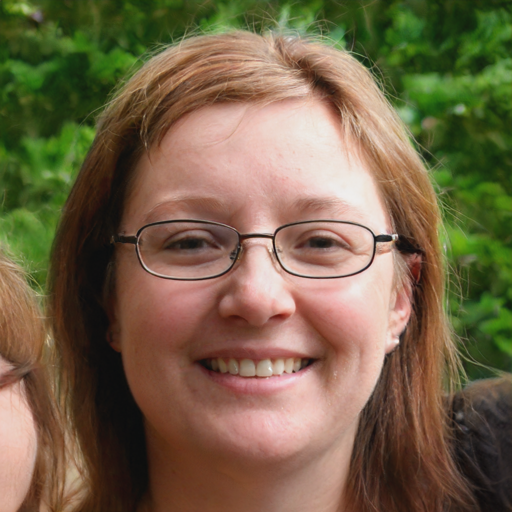

In [7]:
# Latent Optimization Method

from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

# Random Sampling을 통해 Latent Vector 생성
mean_latent = g_ema.mean_latent(4096) #mean_latent() : 평균치의 값을 가지고 있는 latent 

latent_code_init_not_trunc = torch.randn(1, 512).cuda()
with torch.no_grad():
    img_orig, latent_code_init = g_ema([latent_code_init_not_trunc], return_latents=True,
                                truncation=0.7, truncation_latent=mean_latent) #truncation : 특정한 latent vector가 이러한 평균 latent로부터 크게 벗어나지 않도록 latent를 잘라내주는 역할
                                #truncation을 통해 보다 realistic한 image를 생성할 수 있음

# Visualize a random latent vector.
image = ToPILImage()(make_grid(img_orig.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = image.size
image.resize((h // 2, w // 2)) #너비와 높이를 반으로 줄여서 출력한 것 (기본 해상도 : 1024*1024)

In [8]:
# Optimization Method를 사용하여 생성한 latent vector 업데이트

from argparse import Namespace


args = Namespace()
args.description = 'A really sad face' #description : Text Prompt
args.lr_rampup = 0.05
args.lr = 0.1
args.step = 150
args.l2_lambda = 0.005 # 가중치 parameter (원본 image와 비슷해지려는 가중치)
# l2_lambda값이 커지면 커질수록 원본 image와 유사해지려는 힘이 강해짐
# l2_lambda값이 작으면 작을수록 특정한 Text Prompt와 높은 similarity를 갖게 됨
args.save_intermediate_image_every = 1
args.results_dir = 'results'

In [9]:
import os
import math
import torchvision
from torch import optim


# The learning rate adjustment function.
# Learning Rate를 각 스텝마다 적절한 조정을 통해 적용할 수 있도록 함 (Fixed Learning Rate 사용 X) → Optimization을 보다 매끄럽게 진행하기 위함
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp


text_inputs = torch.cat([clip.tokenize(args.description)]).cuda() #Desciption은 Token화된 이후에 CLIP Encoder에 input됨
os.makedirs(args.results_dir, exist_ok=True)

# Initialize the latent vector to be updated.
latent = latent_code_init.detach().clone()
latent.requires_grad = True

clip_loss = CLIPLoss()
optimizer = optim.Adam([latent], lr=args.lr) #Adam Opitimization을 통해 Latent Vector 업데이트

for i in range(args.step):
    # Learning rate 조정
    t = i / args.step
    lr = get_lr(t, args.lr)
    optimizer.param_groups[0]["lr"] = lr

    # Latnet Vector을 이용해서 image 생성
    img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)

    # Loss값 계산
    c_loss = clip_loss(img_gen, text_inputs) # 생성한 image와 input한 text prompt가 유사한 similarity를 갖도록 업데이트
    l2_loss = ((latent_code_init - latent) ** 2).sum() # 초기 latent vector와 유사한 형태를 가지도록 latent vector를 제한하는 loss
    loss = c_loss + args.l2_lambda * l2_loss

    # Gradient 계산해서 Latent Vector 업데이트
    optimizer.zero_grad() 
    loss.backward() # loss를 기반으로 backpropagation
    optimizer.step()

    # Log the current state.
    print(f"lr: {lr}, loss: {loss.item():.4f}")
    if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
        with torch.no_grad():
            img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)
        torchvision.utils.save_image(img_gen, f"results/{str(i).zfill(5)}.png", normalize=True, range=(-1, 1))

with torch.no_grad():
    img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

# Display the initial image and result image.
final_result = torch.cat([img_orig, img_gen])
torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir, "final_result.jpg"), normalize=True, scale_each=True, range=(-1, 1))

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 225MiB/s]


lr: 0.0, loss: 0.8018
lr: 0.013333333333333334, loss: 0.8018
lr: 0.02666666666666667, loss: 0.7861
lr: 0.04, loss: 0.8018
lr: 0.05333333333333334, loss: 0.8174
lr: 0.06666666666666667, loss: 0.8174
lr: 0.08, loss: 0.8071
lr: 0.09333333333333334, loss: 0.7979
lr: 0.1, loss: 0.8018
lr: 0.1, loss: 0.8057
lr: 0.1, loss: 0.8003
lr: 0.1, loss: 0.7944
lr: 0.1, loss: 0.7842
lr: 0.1, loss: 0.7856
lr: 0.1, loss: 0.7798
lr: 0.1, loss: 0.7783
lr: 0.1, loss: 0.7764
lr: 0.1, loss: 0.7729
lr: 0.1, loss: 0.7725
lr: 0.1, loss: 0.7764
lr: 0.1, loss: 0.7827
lr: 0.1, loss: 0.7778
lr: 0.1, loss: 0.7759
lr: 0.1, loss: 0.7695
lr: 0.1, loss: 0.7686
lr: 0.1, loss: 0.7705
lr: 0.1, loss: 0.7686
lr: 0.1, loss: 0.7661
lr: 0.1, loss: 0.7671
lr: 0.1, loss: 0.7700
lr: 0.1, loss: 0.7681
lr: 0.1, loss: 0.7632
lr: 0.1, loss: 0.7671
lr: 0.1, loss: 0.7700
lr: 0.1, loss: 0.7671
lr: 0.1, loss: 0.7637
lr: 0.1, loss: 0.7603
lr: 0.1, loss: 0.7642
lr: 0.1, loss: 0.7622
lr: 0.1, loss: 0.7656
lr: 0.1, loss: 0.7666
lr: 0.1, loss: 

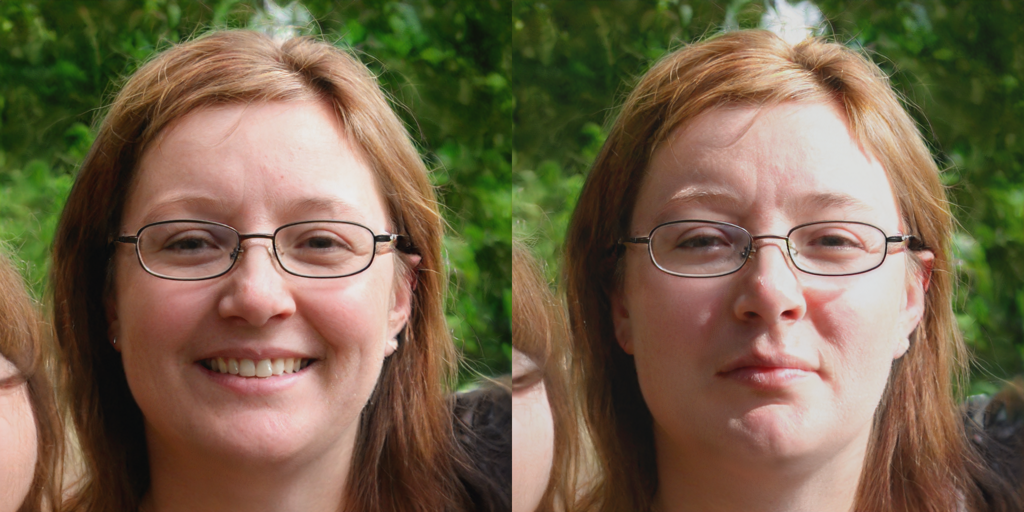

In [10]:
# 결과값 출력

result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))